In [1]:

from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn import ensemble
from sklearn.svm import NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
from numba import prange
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
MODELS = {DecisionTreeRegressor, ensemble.ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, NuSVR, ExtraTreeRegressor,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, MLPRegressor, LassoLarsIC,
          ElasticNet, SGDRegressor, LassoLars, Lasso, LinearSVR, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor}


In [3]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv').sample(5000)
quality = pd.read_csv(r'./datasets/winequality-red.csv')


In [4]:
housing


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21285,832700170,20150421T000000,319000.0,2,1.50,1090,847,3.0,0,0,...,8,1090,0,2009,0,98133,47.7235,-122.352,1090,1118
1470,2523039239,20140530T000000,260000.0,3,1.75,1050,5850,1.0,0,0,...,7,1050,0,1980,0,98166,47.4574,-122.358,1220,8880
7608,4077800026,20140530T000000,715000.0,4,1.75,3420,7200,1.0,0,3,...,8,1770,1650,1947,0,98125,47.7081,-122.277,2450,6200
14655,1257201530,20140513T000000,620000.0,3,1.00,1710,4050,1.5,0,0,...,7,1710,0,1909,0,98103,47.6732,-122.331,1790,4896
679,7852070060,20140731T000000,1145000.0,4,3.50,4370,18361,2.0,0,0,...,11,4370,0,2001,0,98065,47.5440,-121.872,4190,13641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440,3790700110,20141201T000000,225000.0,4,2.50,1700,6031,2.0,0,0,...,8,1700,0,1994,0,98030,47.3582,-122.191,1930,6035
1891,2314300200,20141021T000000,449500.0,4,3.00,2580,7299,2.0,0,0,...,8,2580,0,1998,0,98058,47.4646,-122.150,2250,6165
9232,7214700580,20140608T000000,510000.0,4,2.25,2450,62290,2.0,0,0,...,8,2450,0,1976,0,98077,47.7603,-122.074,2450,41181
981,1777500160,20150425T000000,718000.0,5,3.00,3070,9804,1.0,0,0,...,9,1740,1330,1968,0,98006,47.5702,-122.128,2550,9689


In [5]:
quality


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
housing = housing.dropna()
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 21285 to 15594
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [7]:
quality.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
def metrics(tt, tp, vt, vp, model,
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name,
                 time_it: bool = False):
    model = model_name()
    if time_it == True:
        begin = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(model_name):
    Xt, Xv, yt, yv = train_test_split(
        housing_X, housing_y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv,
        model.predict(Xv), model_name, time)


def get_results(X, y, models):
    results = []
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        res = executor.map(get_metrics, models)
        results = [i for i in res if i]
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -
             1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse']
             [1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()


In [9]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 21285 to 15594
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [10]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [11]:
housing_y


21285     319000.0
1470      260000.0
7608      715000.0
14655     620000.0
679      1145000.0
           ...    
4440      225000.0
1891      449500.0
9232      510000.0
981       718000.0
15594    1120000.0
Name: price, Length: 5000, dtype: float64

In [12]:
housing_X = MinMaxScaler().fit_transform(
    RobustScaler().fit_transform(housing_X))


In [13]:
housing_results = get_results(
    housing_X, housing_y, MODELS)


c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\Users\Admin\Desktop\aitfdl\variational-gradient-boosting\env\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4

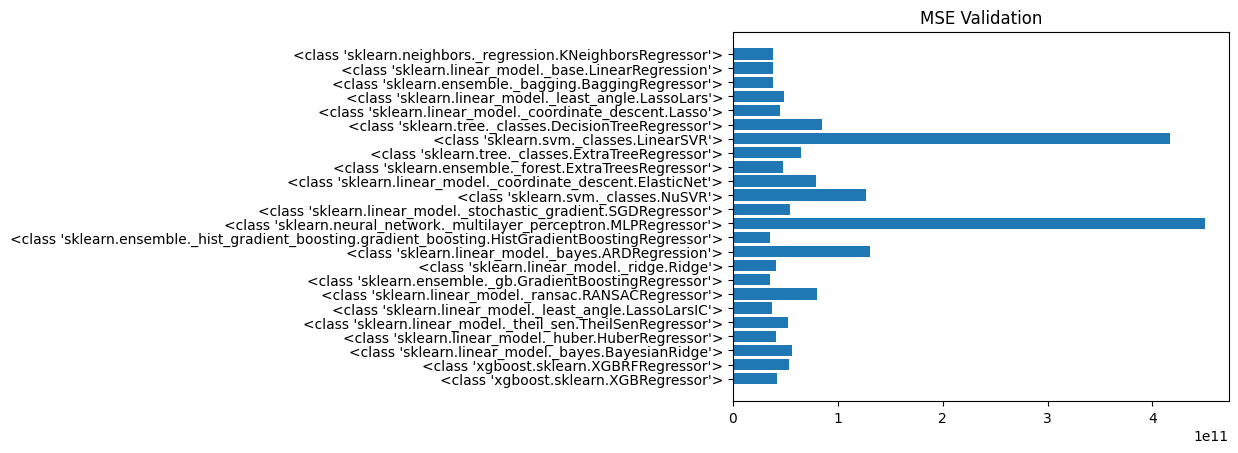

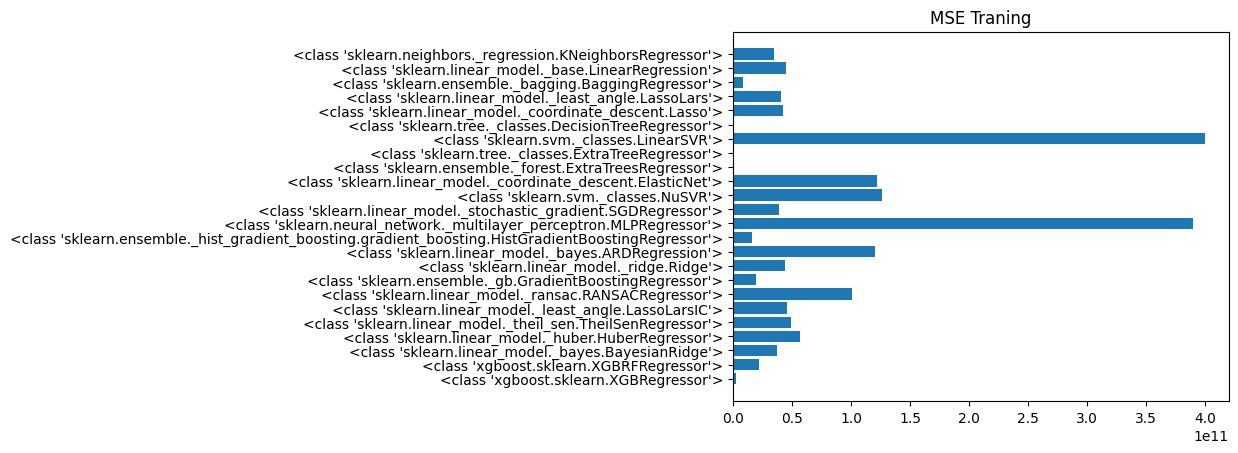

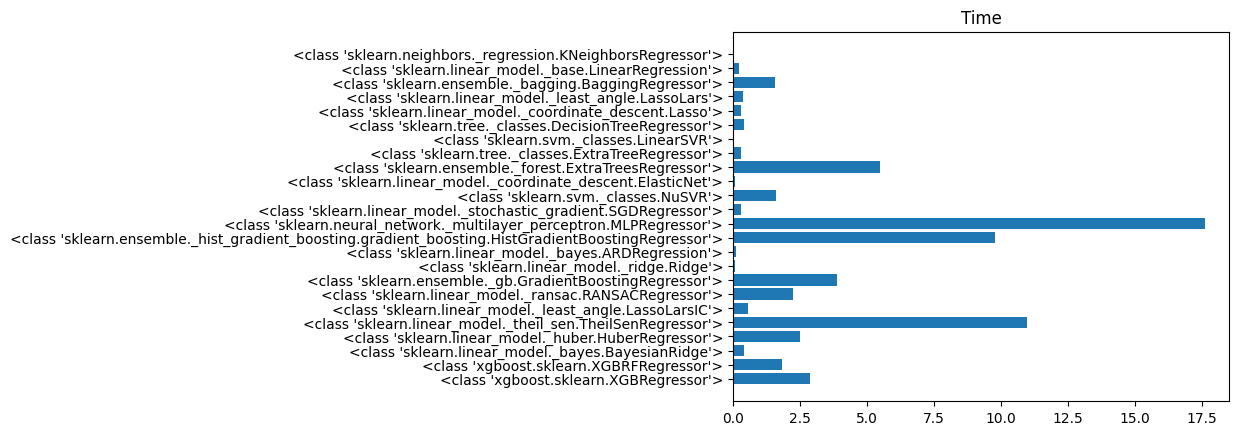

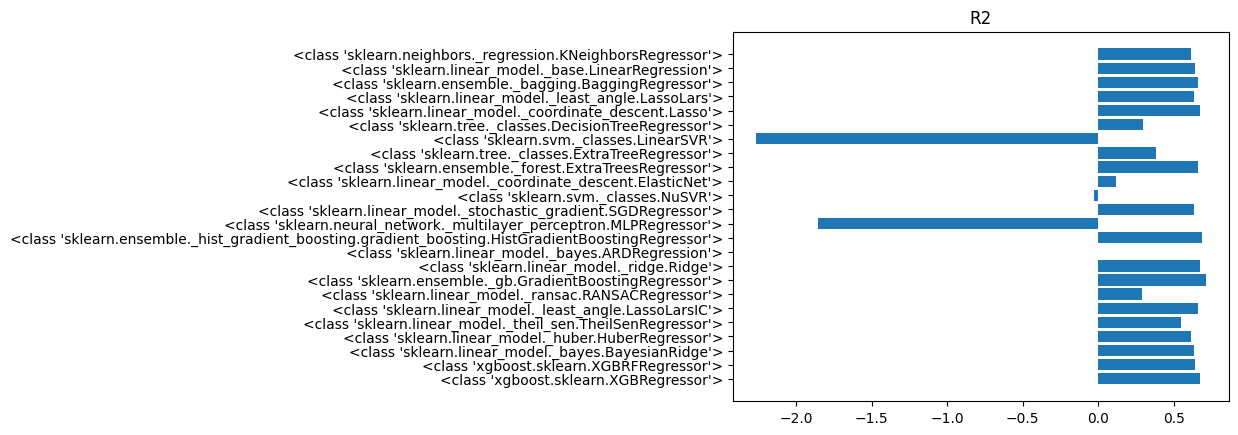

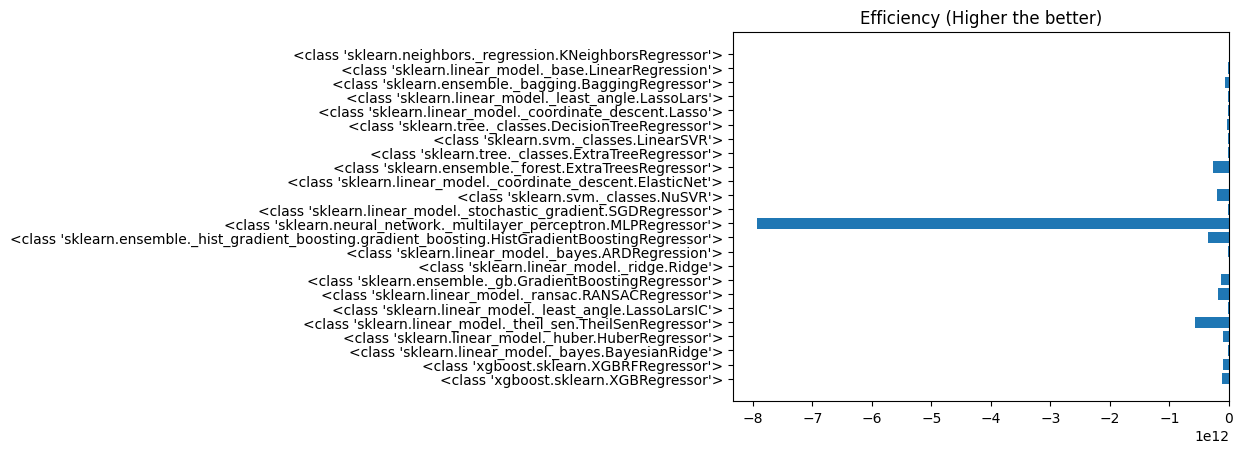

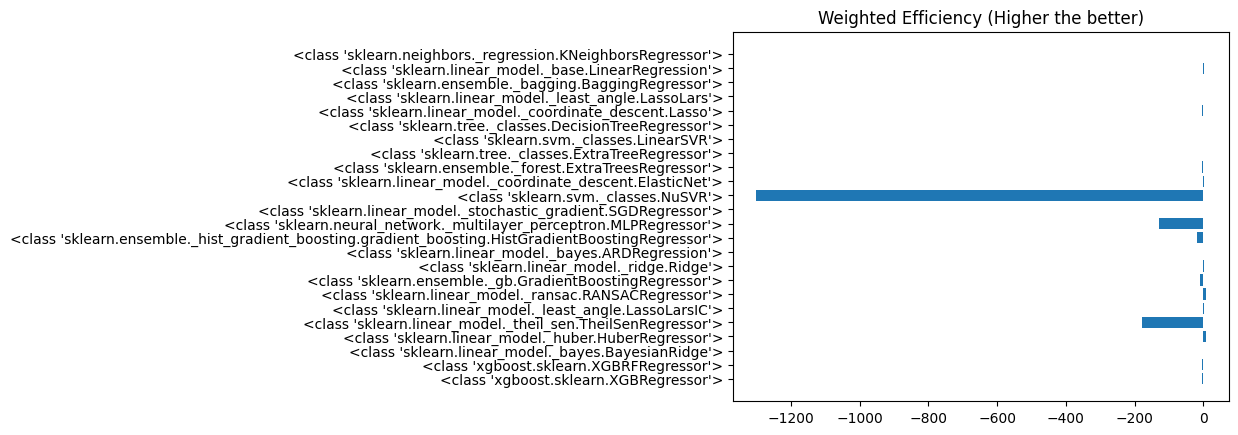

In [14]:
plot_results(housing_results)


In [15]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [46]:
# from VGBoost import VGBRegressor
from numpy import full
from pandas import DataFrame, concat
from numba import prange
from concurrent.futures import ThreadPoolExecutor
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import NuSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from time import perf_counter
from copy import deepcopy


class VGBRegressor(object):
    def __init__(self):
        self._ensemble = []

    def _metrics(self, vt, vp, model, time=None):
        if self.custom_loss_metrics:
            return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
        return {"model": model, "time": time, "loss": mean_squared_error(vt, vp)}

    def _create_model(self, X, y, model_name, time_it: bool = False):
        model = model_name()
        if time_it:
            begin = perf_counter()
            model.fit(X, y)
            end = perf_counter()
            return (model, end - begin)
        return (model.fit(X, y), None)

    def _get_metrics(self, model_name):
        try:
            Xt, Xv, yt, yv = train_test_split(self._X, self._y)
            results = self._create_model(Xt, yt, model_name, time_it=False)
            model, time = results[0], results[1]
            return self._metrics(yv,
                                 model.predict(Xv), model, time)
        except Exception:
            return None

    def _get_results(self, X, y) -> list:
        results = []
        try:
            self._X = MinMaxScaler().fit_transform(RobustScaler().fit_transform(X))
        except Exception:
            self._X = MinMaxScaler().fit_transform(RobustScaler().fit_transform(
                KNNImputer(weights='distance').fit_transform(X)))
        self._y = y
        with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
            res = executor.map(self._get_metrics, self._models)
            results = [i for i in res if i]
        return results

    def fit(
        self, X_train, y_train,
        early_stopping: bool = False,
        early_stopping_min_delta: float = 0.001,
        early_stopping_patience: int = 10,
        custom_models: list = None,
        learning_rate: float = 0.05,
        n_estimators: int = 30,
        warm_start: bool = False,
        complexity: bool = False,
        custom_loss_metrics: object = False,
    ):
        if custom_models:
            self._models = custom_models
        self.custom_loss_metrics = custom_loss_metrics
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.early_stopping = early_stopping
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_patience = early_stopping_patience
        if custom_models:
            self._models = custom_models
        else:
            if complexity:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor,
                                ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor,
                                BaggingRegressor, NuSVR, XGBRegressor, SGDRegressor, KernelRidge, MLPRegressor,
                                Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC)
            else:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor,
                                ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor,
                                Ridge, ARDRegression, RANSACRegressor, LassoLarsIC)
        X_train = deepcopy(X_train)
        self._y_init = y_train
        # base model: mean
        # computer residuals: y - y hat
        # for n_estimators: a) y = prev residuals && residuals * learning rate
        # add early stopping
        # restore best weights
        # ada boost and adaptive scaling for learning rates

        preds = DataFrame(
            data={'yt': y_train, 'p0': full((len(y_train)), y_train.mean(skipna=True))})
        residuals = DataFrame(
            data={'r0': y_train - y_train.mean(skipna=True)})
        errors = []
        if not early_stopping:
            if warm_start:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    if i % 3 == 0:
                        X_train[f"r{i}"] = residuals[f'r{i}'].copy()
                    try:
                        errors.append(mean_squared_error(
                            preds['yt'], preds[f'p{i}']))
                    except Exception:
                        df = concat(
                            [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
                        errors.append(mean_squared_error(
                            df['yt'], df[f"p{i - 1}"]))
                    self._ensemble.append(min_model)
            else:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    errors.append(mean_squared_error(
                        preds['yt'], preds[f'p{i}']))
                    self._ensemble.append(min_model)
                    if errors[i - 1] == 0:
                        break
        else:
            return "TODO"
        min_error = min(errors)
        min_error_i = [i for i in prange(
            len(errors)) if errors[i] == min_error][0]
        self._ensemble, errors = self._ensemble[:
                                                min_error_i], errors[:min_error_i]
        residuals = residuals[:len(errors)]
        return self._ensemble, (residuals, errors)
    
    def predict(self, X_test):
        X_test = deepcopy(X_test)



In [47]:
models = VGBRegressor()


In [48]:
import warnings
warnings.filterwarnings("ignore")


In [49]:
models = models.fit(quality_X, quality_y,)


In [50]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

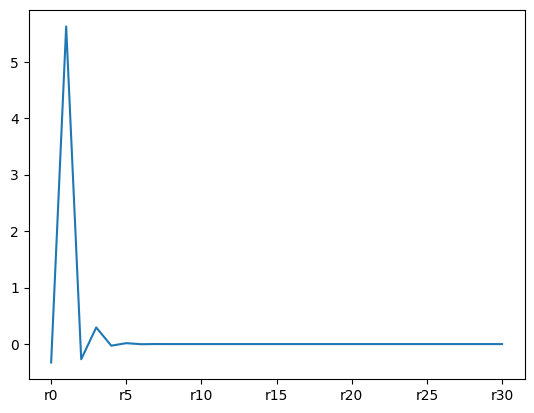

In [51]:
res.mean().plot()


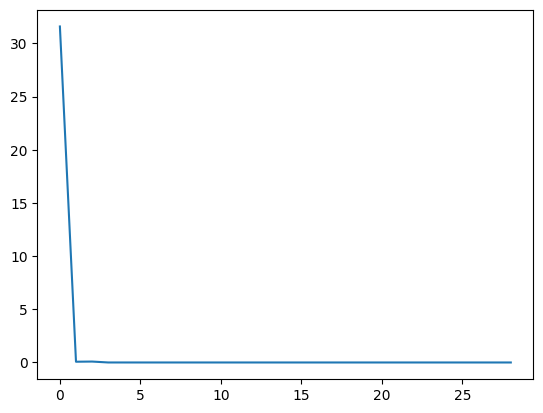

In [52]:
plt.plot(errors)


In [53]:
errors, models


([31.587181475112846,
  0.07036766856893718,
  0.08653855484373224,
  0.0007791954097083076,
  0.0002592584045977903,
  4.838264018400903e-06,
  8.370347859156237e-07,
  2.4237941251536895e-08,
  2.8657214272822856e-09,
  1.0946745783842975e-10,
  1.0238468385913014e-11,
  4.665377719941275e-13,
  3.764986458763878e-14,
  1.9214500838911093e-15,
  1.4145549981526431e-16,
  7.763992729540673e-18,
  5.387487729633953e-19,
  3.098275849270203e-20,
  2.0702947961587348e-21,
  1.226686422582124e-22,
  7.997586076320819e-24,
  4.824799689214518e-25,
  3.093002838171088e-26,
  1.8949341767334005e-27,
  1.139706669481455e-28,
  7.055346970335016e-30,
  7.762805718356861e-31,
  1.480039221803024e-33,
  1.480039221803024e-33],
 [BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  KNeighborsRegr

In [54]:
/len errors


29

In [35]:
models = VGBRegressor()
models = models.fit(quality_X, quality_y, complexity=True,)


In [36]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

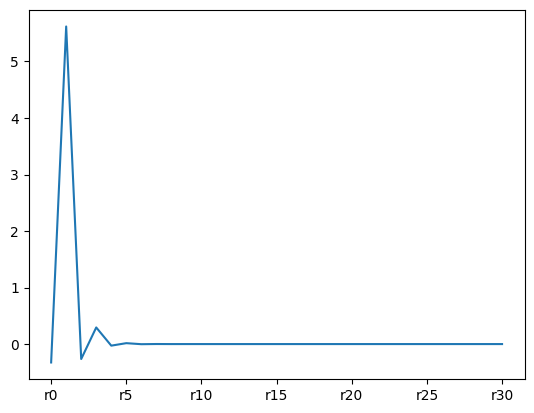

In [37]:
res.mean().plot()


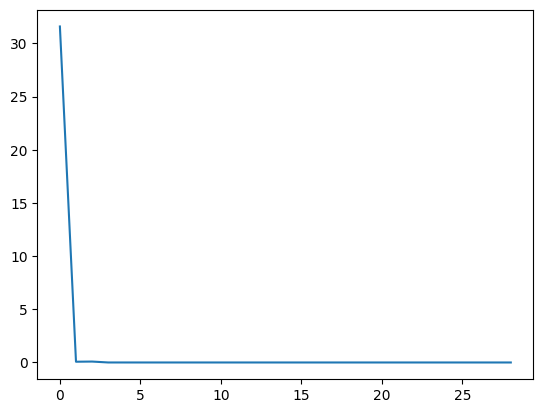

In [38]:
plt.plot(errors)


In [39]:
errors, models


([31.59384464805337,
  0.07066756688793953,
  0.08644669154566809,
  0.0007741341531483164,
  0.00025878691056963076,
  4.8097801678865486e-06,
  8.353447539591609e-07,
  2.4128739330642266e-08,
  2.858570302440753e-09,
  1.0899687946125132e-10,
  1.0210699462761092e-11,
  4.648659810887532e-13,
  3.75844180992756e-14,
  1.917105718123741e-15,
  1.4120286347482228e-16,
  7.747377415717682e-18,
  5.377589155060348e-19,
  3.0919212342367944e-20,
  2.06648587844208e-21,
  1.2243724340641676e-22,
  7.988064533335016e-24,
  4.826334610757397e-25,
  3.103667840465818e-26,
  1.8949341767334005e-27,
  1.1397671044163454e-28,
  7.055346970335016e-30,
  7.762805718356861e-31,
  1.480039221803024e-33,
  1.480039221803024e-33],
 [ExtraTreesRegressor(),
  GradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(),
  GradientBoostingRegressor(

In [40]:
/len errors


29

In [41]:
models = VGBRegressor()  # 19.6


In [42]:
models = models.fit(housing_X, housing_y,)


In [43]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

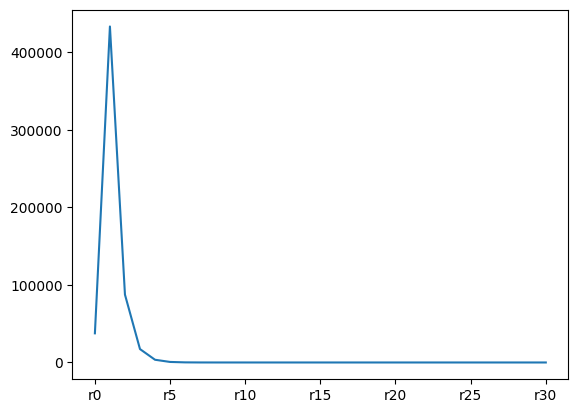

In [44]:
res.mean().plot()


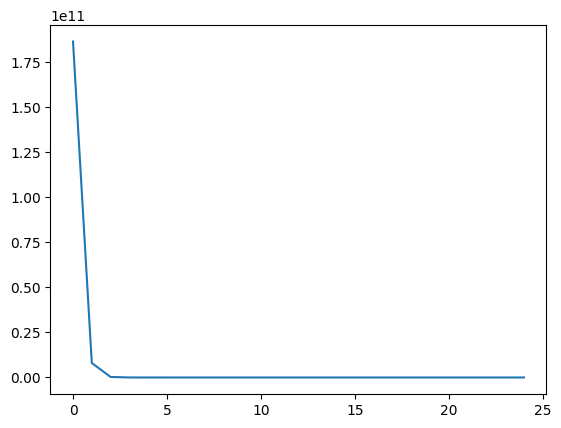

In [45]:
plt.plot(errors)


In [46]:
errors, models


([186485492021.1652,
  8032103228.156619,
  294460754.45723337,
  13233278.76214492,
  463673.9216276453,
  22272.64332892183,
  732.2979737739486,
  38.952092157995125,
  1.18318660333316,
  0.07282929186288822,
  0.002060391138478425,
  0.00015144910043245056,
  4.255943076820881e-06,
  3.6344199689926223e-07,
  1.1321421941218069e-08,
  1.0164164791563578e-09,
  3.7650367961790634e-11,
  3.2295527853784717e-12,
  1.4131910308986952e-13,
  1.1191839292634356e-14,
  5.550772998048058e-16,
  4.0781648247463235e-17,
  1.4065519955079163e-18,
  1.106127620325182e-20,
  1.0640851399882149e-21],
 [BaggingRegressor(),
  BaggingRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  Deci

In [47]:
/len errors


25

In [48]:
models = VGBRegressor()  # 19.6


In [49]:
models = models.fit(housing_X, housing_y, complexity=True)


In [50]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

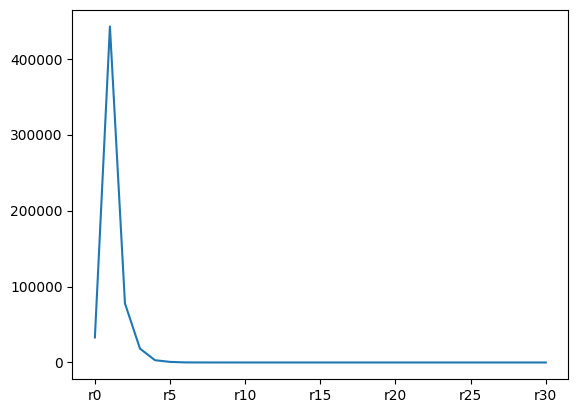

In [51]:
res.mean().plot()


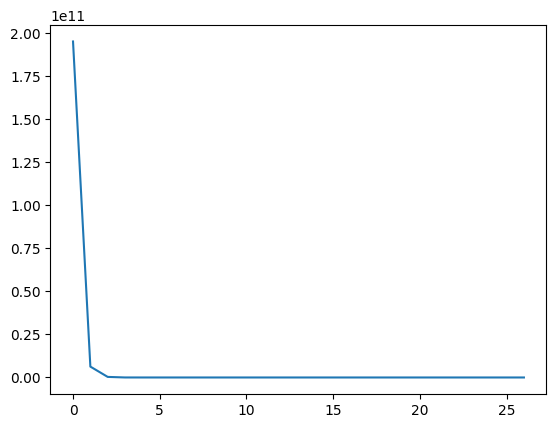

In [52]:
plt.plot(errors)


In [53]:
errors, models


([195218490649.12335,
  6323271220.723579,
  330878568.5615081,
  9567349.41521858,
  580437.6932494717,
  14227.389725199819,
  1074.6726572156358,
  21.212256216108607,
  2.156249674454715,
  0.03455018813803929,
  0.004822472234504091,
  7.434397418278788e-05,
  1.224321000479643e-05,
  2.350999633948885e-07,
  3.518844570775952e-08,
  9.34094235083576e-10,
  1.1202380149431796e-10,
  3.9347284045579465e-12,
  3.83886163195954e-13,
  1.647996082801019e-14,
  1.3805937591777471e-15,
  6.770318397773226e-17,
  5.129524124794331e-18,
  2.8856311871244823e-19,
  1.8409159965740786e-20,
  4.264810889425402e-22,
  2.7105054312137612e-24],
 [ExtraTreesRegressor(),
  BaggingRegressor(),
  GradientBoostingRegressor(),
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='de

In [54]:
/len errors


27